# Variation Autoencoder for MNIST



In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [41]:
# ハイパーパラメータ
batch_size = 128
latent_dim = 2  # 中間層の次元
epochs = 50
learning_rate = 1e-3
beta = 1.0  # KLダイバージェンスの重み

# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [42]:
# VAEモデルの定義
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
#        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        return mu

    def reparameterize(self, mu):
        eps = 1.0 * torch.randn_like(mu)  # $\sigma^2=1.0$
        z = mu + eps
#        z = mu
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu = self.encode(x)
        z = self.reparameterize(mu)
        x_recon = self.decode(z)
        return x_recon, mu



Epoch 1, Loss: 51.8979
Epoch 2, Loss: 46.3934
Epoch 3, Loss: 46.0323
Epoch 4, Loss: 45.8284
Epoch 5, Loss: 45.7034
Epoch 6, Loss: 45.6348
Epoch 7, Loss: 45.5269
Epoch 8, Loss: 45.4489
Epoch 9, Loss: 45.4044
Epoch 10, Loss: 45.3586
Epoch 11, Loss: 45.3584
Epoch 12, Loss: 45.2923
Epoch 13, Loss: 45.2988
Epoch 14, Loss: 45.2624
Epoch 15, Loss: 45.2657
Epoch 16, Loss: 45.2161
Epoch 17, Loss: 45.1780
Epoch 18, Loss: 45.2060
Epoch 19, Loss: 45.2069
Epoch 20, Loss: 45.1942
Epoch 21, Loss: 45.1621
Epoch 22, Loss: 45.1568
Epoch 23, Loss: 45.1609
Epoch 24, Loss: 45.1467
Epoch 25, Loss: 45.1080
Epoch 26, Loss: 45.1328
Epoch 27, Loss: 45.1360
Epoch 28, Loss: 45.0945
Epoch 29, Loss: 45.1003
Epoch 30, Loss: 45.0983
Epoch 31, Loss: 45.0757
Epoch 32, Loss: 45.0957
Epoch 33, Loss: 45.0655
Epoch 34, Loss: 45.0390
Epoch 35, Loss: 45.0569
Epoch 36, Loss: 45.0874
Epoch 37, Loss: 45.0650
Epoch 38, Loss: 45.0429
Epoch 39, Loss: 45.0542
Epoch 40, Loss: 45.0871
Epoch 41, Loss: 45.0666
Epoch 42, Loss: 45.0315
E

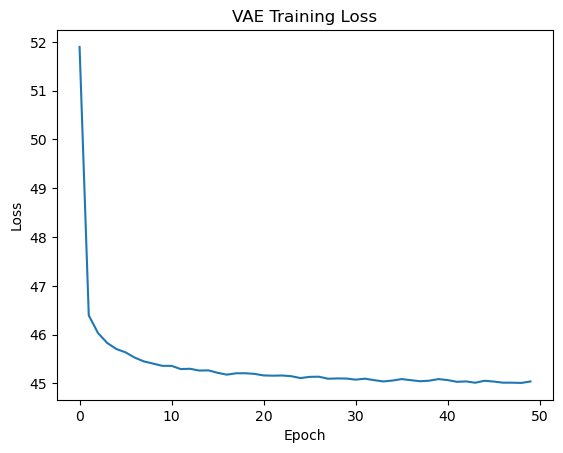

In [43]:
# モデル、損失関数、最適化手法の定義
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
#    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = -0.5 * torch.sum(1 - mu.pow(2))
    return MSE + beta*KLD

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu = model(data)
        loss = loss_function(recon_batch, data, mu)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [47]:
# MSE lossの計算
def calculate_mse_loss(model, data_loader):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            recon_batch, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon_batch.view(-1, 784), data.view(-1, 784), reduction='sum').item()
    return mse_loss / len(data_loader.dataset)
mse_loss = calculate_mse_loss(model, train_loader)
print(f'MSE Loss: {mse_loss:.4f}')


MSE Loss: 41.7689


z_list shape: (60000, 2)


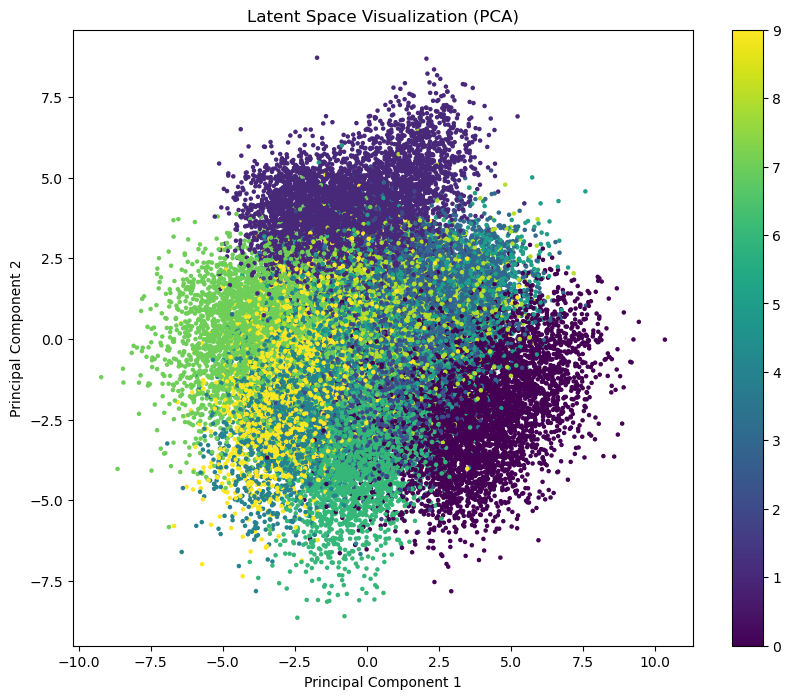

In [44]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        mu = model.encode(data)
        z = model.reparameterize(mu)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

print(f"z_list shape: {z_list.shape}")

# PCAを使用して次元削減
#pca = PCA(n_components=2)
#z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_list[:, 0], z_list[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



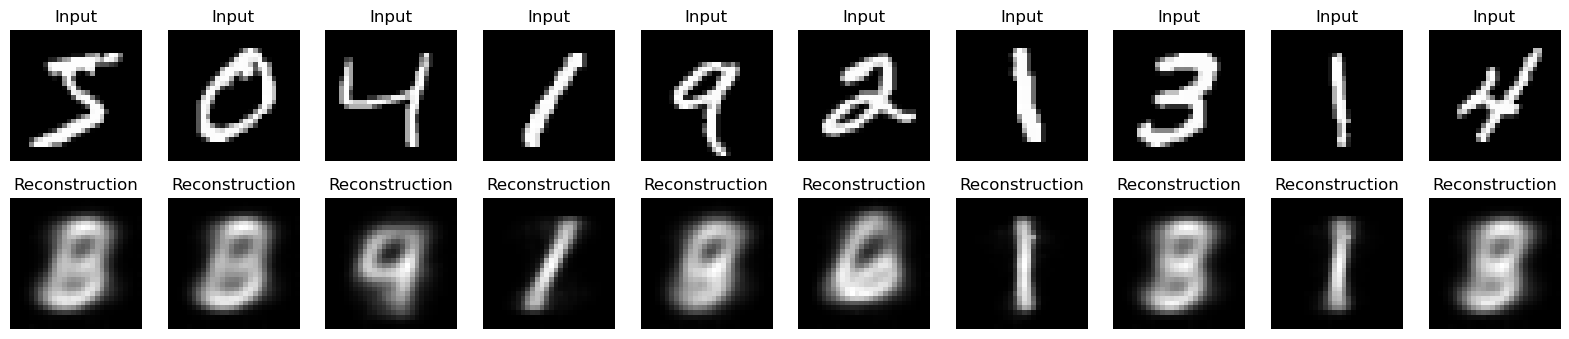

In [45]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        recon_sample, _ = model(sample)
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()